In [80]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import albumentations as A
from albumentations import pytorch as A_torch
from tqdm import tqdm

In [81]:
# hyperparameters
cfg = {
    "image_size": 256,
    "batch_size": 16,
}

In [82]:
df = pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")

In [83]:
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [84]:
df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [85]:
13158 / df.shape[0]

0.6149460204701593

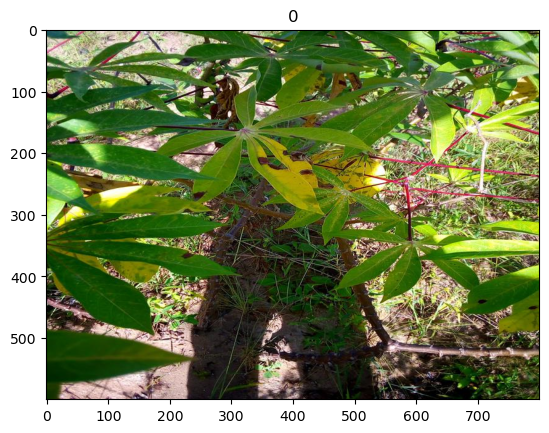

In [86]:
_id = "1000015157.jpg"
image = cv2.imread(f"/kaggle/input/cassava-leaf-disease-classification/train_images/{_id}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title(df[df["image_id"] == _id].iloc[0]["label"])
plt.imshow(image)

In [87]:
df_train, df_valid = train_test_split(df, test_size=0.2, shuffle=True)

In [88]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        self.names = df["image_id"].values
        self.targets = df["label"].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, index):
        image_name = self.names[index]
        image = cv2.imread(f"/kaggle/input/cassava-leaf-disease-classification/train_images/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (cfg["image_size"], cfg["image_size"]))
        
        image = self.transforms(image=image)["image"]
        
        y = torch.tensor(self.targets[index], dtype=torch.long)
        
        return image, y

In [89]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Normalize(p=1.),
        A_torch.ToTensorV2(p=1.),
    ]
)

valid_transforms = A.Compose(
    [
        A.Normalize(p=1.),
        A_torch.ToTensorV2(p=1.),
    ]
)

In [90]:
train_dataset = Dataset(df_train, train_transforms)
valid_dataset = Dataset(df_valid, valid_transforms)

In [91]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=4,
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=4,
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


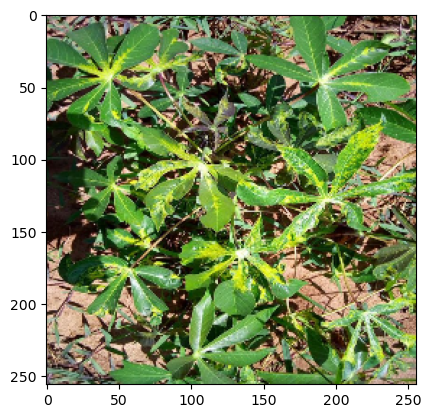

tensor([3, 3, 3, 4, 3, 1, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3])


In [92]:
def denormalize_image(image):
    return image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

for x, y in train_dataloader:
    plt.imshow(denormalize_image(x[0].permute(1, 2, 0)))
    plt.show()
    print(y)
    break

In [93]:
# 0-255 -> mean=0 std=1

# -1...1

In [94]:
class LossMeter:
    def __init__(self):
        self.losses = []
    
    def update(self, val):
        self.losses.append(val)
        return np.mean(self.losses)
    
    def __call__(self):
        return np.mean(self.losses)

    
class AccMeter:
    def __init__(self):
        self.accs = [] # False, True, True, ...
    
    def update(self, y_true, y_pred):
        # n, n*5
        y_pred = y_pred.argmax(axis=1).astype(int)
        self.accs.extend(y_true == y_pred)
        return np.mean(self.accs)

    def __call__(self):
        return np.mean(self.accs)

In [95]:
class Trainer:
    def __init__(self, device, model, optimizer, criterion):
        self.device = device
        self.model = model 
        self.optimizer = optimizer 
        self.criterion = criterion
    
    def fit(self, epochs, train_loader, valid_loader):
        for epoch in range(epochs):
            print(epoch)
        
            self.train_epoch(train_loader)
            self.valid_epoch(valid_loader)
        
    def train_epoch(self, loader):
        self.model.train()
        train_loss = LossMeter()
        train_acc = AccMeter()
        for X, y in tqdm(loader):
            X = X.to(self.device)
            y = y.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(X)
            
            loss = self.criterion(outputs, y)
            loss.backward()
            
            self.optimizer.step()
            
            train_loss.update(loss.detach().item())
            train_acc.update(y.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        
        print(f"{train_loss()=} {train_acc()=}")
    
    def valid_epoch(self, loader):
        self.model.eval()
        valid_loss = LossMeter()
        valid_acc = AccMeter()
        for X, y in tqdm(loader):
            X = X.to(self.device)
            y = y.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X)

            loss = self.criterion(outputs, y)
            
            valid_loss.update(loss.detach().item())
            valid_acc.update(y.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        
        print(f"{valid_loss()=} {valid_acc()=}")
        
    def save_model(self, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
            },
            save_path,
        )

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=5, bias=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
trainer = Trainer(device, model, optimizer, criterion)

In [98]:
trainer.fit(10, train_dataloader, valid_dataloader)

0


100%|██████████| 1070/1070 [02:27<00:00,  7.23it/s]


train_loss()=0.7513625846566441 train_acc()=0.7282234036338143


100%|██████████| 268/268 [00:33<00:00,  8.11it/s]


valid_loss()=0.5964166143102877 valid_acc()=0.7964953271028037
1


100%|██████████| 1070/1070 [02:25<00:00,  7.35it/s]


train_loss()=0.6052965621107093 train_acc()=0.7851843196821873


100%|██████████| 268/268 [00:32<00:00,  8.19it/s]


valid_loss()=0.5646545908955941 valid_acc()=0.7985981308411215
2


100%|██████████| 1070/1070 [02:27<00:00,  7.27it/s]


train_loss()=0.5706654725718164 train_acc()=0.7987965180814395


100%|██████████| 268/268 [00:32<00:00,  8.13it/s]


valid_loss()=0.5512370523343335 valid_acc()=0.8154205607476636
3


100%|██████████| 1070/1070 [02:26<00:00,  7.30it/s]


train_loss()=0.5365800563141564 train_acc()=0.8143366244084828


100%|██████████| 268/268 [00:34<00:00,  7.88it/s]


valid_loss()=0.49326795898377895 valid_acc()=0.8303738317757009
4


100%|██████████| 1070/1070 [02:26<00:00,  7.31it/s]


train_loss()=0.5169876624490614 train_acc()=0.820295612548928


100%|██████████| 268/268 [00:32<00:00,  8.15it/s]


valid_loss()=0.5133569246269206 valid_acc()=0.8364485981308412
5


100%|██████████| 1070/1070 [02:29<00:00,  7.14it/s]


train_loss()=0.4936962224125305 train_acc()=0.8309283168779575


100%|██████████| 268/268 [00:34<00:00,  7.88it/s]


valid_loss()=0.515524336526087 valid_acc()=0.8254672897196261
6


100%|██████████| 1070/1070 [02:26<00:00,  7.32it/s]


train_loss()=0.47805777340431077 train_acc()=0.8333820178769644


100%|██████████| 268/268 [00:32<00:00,  8.19it/s]


valid_loss()=0.4829254478369075 valid_acc()=0.8397196261682243
7


100%|██████████| 1070/1070 [02:27<00:00,  7.26it/s]


train_loss()=0.4605946966003035 train_acc()=0.839048898755623


100%|██████████| 268/268 [00:32<00:00,  8.13it/s]


valid_loss()=0.4769588800202777 valid_acc()=0.8373831775700935
8


100%|██████████| 1070/1070 [02:28<00:00,  7.23it/s]


train_loss()=0.44534627887133127 train_acc()=0.8482210667757201


100%|██████████| 268/268 [00:33<00:00,  7.92it/s]


valid_loss()=0.5197174853798169 valid_acc()=0.8203271028037383
9


100%|██████████| 1070/1070 [02:27<00:00,  7.28it/s]


train_loss()=0.4327868586353888 train_acc()=0.850499503417655


100%|██████████| 268/268 [00:32<00:00,  8.16it/s]

valid_loss()=0.484226516475762 valid_acc()=0.8303738317757009


In [103]:
# conv-conv-pool-conv-con-pool-...-dense-dense